In [1]:
import glob
#from pathlib import Path
import json
import preprocessing as pp
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

2023-12-26 10:18:43.267067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 10:18:43.267148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 10:18:43.320152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 10:18:43.434555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 10:18:46.161913: W tensorflow/compiler/tf2

In [67]:
length = 5
n_features=3
max_embed_length=500
out_embed_dim=3
label_length=1
training_frames = length + label_length
batch_size = 32

In [3]:
keys_to_dtype = {
  #'developer_token_id': tf.int64,
  #'resource_token_id': tf.int64,
  #'screen_caption_token_ids': tf.int64,
  #'appdesc_token_id': tf.int64,
  'clickable_seq': tf.int64,
  'type_id_seq': tf.int64,
  'cord_x_seq': tf.float32,
  'cord_y_seq': tf.float32,
  'visibility_to_user_seq': tf.int64,
  'visibility_seq': tf.int64,
  #'attended_objects': tf.int64,
  #'label_flag': tf.int64,  # 0: padding 1: node
  # 'obj_img_mat': tf.int64,
  'obj_dom_pos': tf.int64,
  #'attention_boxes': tf.float32,
  #'gold_caption': tf.string,
}

In [4]:
def get_features_from_gestures(gesture_path):
  with tf.io.gfile.GFile(gesture_path) as f:
    gesture_json = json.load(f)
  trace_path = gesture_path.replace('gestures.json', '')
  # Throw away all gestures except the first
  gesture_items = list(gesture_json.items())
  # Remove empty gestures
  gesture_items = [gesture for gesture in gesture_items if gesture[1]]
  # TODO: Add column: isSwipe, if gesture has more than one entry
  if gesture_items and gesture_items[0]:
    gesture_dict = {gesture[0]:gesture[1][0] for gesture in gesture_items}
  else:
    gesture_dict = {}

  first_gesture_item = list(gesture_dict.items())
  if (not gesture_dict) or (not first_gesture_item[0]) or (not first_gesture_item[0][1]):
    # Return empty dataframe, if no data is available
    return pd.DataFrame(columns=['x', 'y']), trace_path
  
  gesture_df = pd.DataFrame(gesture_dict).transpose()
  gesture_df.columns = ['x', 'y']
  return gesture_df, trace_path

In [5]:
# def to_var_len_feature_dict(entries):
#   dict = {}
#   for feature_item in entries:
#     dict[feature_item[0]] = tf.convert_to_tensor(feature_item[1], dtype=keys_to_dtype[feature_item[0]])
#   return dict


In [6]:
#pathToCombined = "D:/Tmp/Coding/datasets/RICO/unique_uis/test_dataset"
#pathToFilteredTraces = D:\Tmp\Coding\datasets\RICO\traces\filtered_traces
traces_prefix = "../sources/datasets/RICO/traces/filtered_traces"
path_to_gesture_json = f"{traces_prefix}/*/trace_*/gestures.json"
path_to_gesture_json

'../sources/datasets/RICO/traces/filtered_traces/*/trace_*/gestures.json'

In [7]:
gesture_json_paths = glob.glob(path_to_gesture_json)
len(gesture_json_paths)

10292

In [8]:
def get_features_from_tree(frame_index, trace_path):
  file_prefix = f"{trace_path}view_hierarchies/{frame_index}"
  features_dict = pp.create_simple_features(file_prefix)
  if features_dict is None:
    return None
  del features_dict['node_id']
  feature_items = list(features_dict.items())
  #feature_items = to_var_len_feature_dict(feature_items).items()
  tree_feature_df = pd.DataFrame(feature_items, columns=['feat', frame_index])
  tree_feature_df = tree_feature_df.set_index('feat')
  tree_feature_df = tree_feature_df.transpose()
  return tree_feature_df
  #return pd.DataFrame(features_adapt, index=[frame_index])

In [9]:
gesture_path = gesture_json_paths[43]
gesture_df, trace_path = get_features_from_gestures(gesture_path)
frameIndex = gesture_df.index.values[0]
feature_df = get_features_from_tree(frameIndex, trace_path)
feature_df
#feature_item = features[0]
#feature_item
#tf.convert_to_tensor(feature_item[1], dtype=keys_to_dtype[feature_item[0]])

feat,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq,cord_y_seq
391,"[1, 1, 7, 2, 2, 6, 2, 6, 2, 2, 7, 1, 3, 3, 5, ...","[4, 4, 4, 4, 4, 4, 4]","[1, 1, 1, 1, 0, 1, 1]","[1, 1, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 1]","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],..."


In [10]:
# for t,v in keys_to_dtype.items():
#     print(feature_df[t]['4758'][0].dtype)

In [11]:
# Try without features for now, only gestures
all_feat_df = pd.concat([gesture_df, feature_df], axis=1)
#all_feat_df = gesture_df
all_feat_df

,x,y,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq,cord_y_seq
391,0.515094,0.732075,"[1, 1, 7, 2, 2, 6, 2, 6, 2, 2, 7, 1, 3, 3, 5, ...","[4, 4, 4, 4, 4, 4, 4]","[1, 1, 1, 1, 0, 1, 1]","[1, 1, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 1]","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],..."


In [12]:
#feature_df['type_id_seq'].iloc[0][0].dtype

In [13]:
 # Get set of frames for each screen, but don't mix them during training LSTM
feature_traces = pd.DataFrame()
use_embeddings = True

trace_progress = 0
for trace_id, gesture_path in enumerate(gesture_json_paths):
    trace_progress = trace_progress + 1
    if trace_progress % 100 == 0:
      print(f'Processed {trace_progress} of {len(gesture_json_paths)} ({trace_progress/len(gesture_json_paths):.0%}) traces.\r', end="")
    gesture_df, trace_path = get_features_from_gestures(gesture_path)
    # Traces with too few frames will be dropped
    if len(gesture_df) < training_frames:
        #print(f'Gesture (traceID: {trace_id}) has only {len(gesture_df)} of {training_frames} required frames: {gesture_path}')
        continue
    if use_embeddings: # Try without features for now, only gestures
        tree_features_df = pd.DataFrame()
        for frame_id in gesture_df.index.values:
            tree_feature_df = get_features_from_tree(frame_id, trace_path)
            if tree_feature_df is None:
              print(f'Frame {frame_id} has no feature data')
              continue
            tree_features_df = pd.concat([tree_features_df, tree_feature_df], axis=0)
        trace_features_df = pd.concat([gesture_df, tree_features_df], axis=1)
    else:
        trace_features_df = gesture_df
    trace_features_df['trace_id'] = trace_id
    feature_traces = pd.concat([feature_traces, trace_features_df], axis=0)

len(feature_traces)
        

Frame 7384 has no feature datatraces.
Frame 341 has no feature data traces.
Frame 521 has no feature data traces.


50304

In [14]:
feature_traces.head()

,x,y,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq,cord_y_seq,trace_id
370,0.825156,0.351732,"[1, 1, 251, 2, 2, 250, 2, 250, 2, 2, 251, 1, 3...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],...",3
488,0.373016,0.224026,"[1, 1, 251, 2, 2, 250, 2, 250, 2, 2, 251, 1, 3...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],...",3
526,0.563492,0.898268,"[1, 1, 251, 2, 2, 250, 2, 250, 2, 2, 251, 1, 3...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],...",3
614,0.169072,0.336580,"[1, 1, 251, 2, 2, 250, 2, 250, 2, 2, 251, 1, 3...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],...",3
642,0.346080,0.136364,"[1, 1, 143, 2, 2, 142, 2, 142, 2, 2, 143, 1, 3...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],...",3


In [15]:
feature_traces.describe()

,x,y,trace_id
count,50304.000000,50304.000000,50304.000000
mean,0.436052,0.455192,5148.693285
std,0.287890,0.321706,2975.276707
min,0.001040,0.002165,3.000000
25%,0.196008,0.127778,2534.000000
50%,0.426058,0.424784,5143.000000
75%,0.661400,0.768707,7726.000000
max,1.000000,0.998665,10291.000000


In [16]:
import math
import statistics

# Preprocess data
feature_traces_preprocessed = feature_traces
print(len(feature_traces_preprocessed))
feature_traces_preprocessed = feature_traces_preprocessed.dropna()
feature_traces_preprocessed = feature_traces_preprocessed[['x','y', 'obj_dom_pos', 'trace_id']]
print(len(feature_traces_preprocessed))
# for t,v in keys_to_dtype.items():
#   # try to convert float to list
#   feature_traces_preprocessed[t] = feature_traces_preprocessed[t].apply(lambda x : [np.nan if (y is None or isinstance(y, float)) else y for y in x] if isinstance(x, list) else [x])
# 
# #lens of list
# print(feature_traces_preprocessed.isna().sum())
# feature_traces_preprocessed

# List of median value count for each feature.
feat_median_array_length = {}

# Check if feature is an array
isFeatList = (feature_traces_preprocessed.map(type) == list).all(axis='rows')
max_dom_pos = 500 # see screen2words
for feat_name, isList in isFeatList.items():
  if isList:
    median_value = statistics.median(feature_traces_preprocessed[feat_name].map(len))
    feat_median_array_length[feat_name] = median_value
    print(f'Preprocess "{feat_name}" with median array length of {median_value}')
    # Remove all NaN
    feature_traces_preprocessed[feat_name] = feature_traces_preprocessed[feat_name].map(lambda row: [x for x in row if not math.isnan(x)])
    # Pad all values to same length
    feat_pad = keras.utils.pad_sequences(feature_traces_preprocessed[feat_name], value=0, padding='post', maxlen=max_dom_pos)
    print(f'Feature "{feat_name}" has max array length of {len(feat_pad[0])}')
    feature_traces_preprocessed[feat_name] = feat_pad.tolist()

feat_median_array_length

50304
50301
Preprocess "obj_dom_pos" with median array length of 231
Feature "obj_dom_pos" has max array length of 500


{'obj_dom_pos': 231}

In [17]:
# feature_traces_flatten = feature_traces_preprocessed
# for feat_name, isList in isFeatList.items():
#   if isList:
#     max_len = len(feature_traces_flatten[feat_name])
#     feature_traces_flatten = feature_traces_flatten.drop(feat_name, axis= 1)
#     feature_traces_flatten[[f'{feat_name}_{i}' for i in max_len]] = pd.DataFrame(feature_traces_preprocessed[feat_name].tolist(), index= feature_traces_preprocessed.index)
#     #feature_traces_preprocessed = feature_traces_preprocessed + feature_traces_preprocessed.teams.apply(pd.Series)
#     #df3.columns = ['team1', 'team2']

In [18]:
feature_traces_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50301 entries, 370 to 1453
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x            50301 non-null  float64
 1   y            50301 non-null  float64
 2   obj_dom_pos  50301 non-null  object 
 3   trace_id     50301 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.9+ MB


In [19]:
# The data is split by trace and not by frame windows as otherwise the model would be trained with similar apps before
feature_traces_list = [pd.DataFrame(x[1]).drop('trace_id', axis=1) for x in feature_traces_preprocessed.groupby('trace_id')]

In [20]:
feature_traces_list[0]
# len(feature_traces_preprocessed[0].iloc[0]['obj_dom_pos'])

,x,y,obj_dom_pos
370,0.825156,0.351732,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
488,0.373016,0.224026,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
526,0.563492,0.898268,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
614,0.169072,0.336580,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
642,0.346080,0.136364,"[1, 1, 143, 2, 2, 142, 2, 142, 2, 2, 143, 1, 3..."
683,0.413420,0.257576,"[152, 75, 10, 153, 74, 10, 154, 73, 10, 158, 6..."
688,0.090188,0.070346,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
700,0.257576,0.786797,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
709,0.078644,0.900433,"[13, 230, 11, 22, 221, 11, 28, 215, 11, 50, 19..."
736,0.159452,0.980519,"[1, 1, 130, 2, 2, 129, 3, 3, 128, 3, 130, 1, 4..."


In [21]:
# padding_info = [('screen_caption_token_ids', [1, None], 0),
#                   ('appdesc_token_id', [1, None], 0),
#                   ('label_flag', [None], 0),
#                   ('obj_pixels', [None, 64, 64, 1], 0.0),
#                   ('obj_type', [None], -1), ('obj_clickable', [None], 0),
#                   ('obj_screen_pos', [None, 4], 0),
#                   ('obj_dom_pos', [None, 3], 0), ('obj_visible', [None], 0),
#                   ('attention_boxes', [1, 5, 4], 0.0),
#                   ('attended_objects', [1, None], 0),
#                   ('references', [None], tf.cast('', tf.string))]
# padded_shapes = {}
# padded_values = {}
# for (key, padding_shape, padding_value) in padding_info:
#   padded_shapes[key] = padding_shape
#   padded_values[key] = padding_value

In [22]:
# tmp = pd.DataFrame(columns=['x','y', 'obj_dom_pos'], data=[[0.5,0.5,[1,2]],[0.5,0.5,[1,2,3]]], index=[1,2])
# tmp['obj_dom_pos'].to_dict()


# data = tf.data.Dataset.from_generator(lambda: tmp['obj_dom_pos'], output_signature=(
#   tf.TensorSpec(shape=(), dtype=tf.string),
#   tf.RaggedTensorSpec(shape=(), dtype=tf.int32),
# ))


In [23]:


# dataset = tf.data.Dataset.from_tensor_slices(data)
# dataset = dataset.map(lambda x: x.to_tensor()) # convert ragged -> uniform
# 
# #data = tmp['obj_dom_pos']
# batch_size = 64
# data = data.padded_batch(
#   batch_size, padded_shapes=padded_shapes, padding_values=padded_values)
# data = data.prefetch(buffer_size=1024)
# data

#feature_traces_list = [tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp]

In [24]:
test_size = len(feature_traces_list) // 4
test_ind = len(feature_traces_list) - test_size

train_traces = feature_traces_list[:test_ind]
test_traces = feature_traces_list[test_ind:]

In [25]:
#df['obj_dom_pos'].dtype

In [50]:
from keras.layers import Normalization

isScale = False
if isScale:
  scaler = Normalization()
  scaler_invert = Normalization(invert=True)
  
  print('Adapt scaler')
  for train in train_traces:
    scaler.adapt(train[['x','y']])
    scaler_invert.adapt(train[['x','y']])
  
  print('Scale train data')
  scaled_train_traces = train_traces
  for train in train_traces[['x','y']]:
    scaled_train_traces[['x','y']] = scaler(train)
  
  print('Scale test data')
  scaled_test_traces = test_traces
  for test in test_traces[['x','y']]:
    scaled_test_traces[['x','y']] = scaler(test)
  
  print(scaler_invert(scaled_train_traces[0]))
else:
  scaled_train_traces = train_traces
  scaled_test_traces = test_traces
  

In [51]:
scaled_train_traces[0]


,x,y,obj_dom_pos
370,0.825156,0.351732,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
488,0.373016,0.224026,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
526,0.563492,0.898268,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
614,0.169072,0.336580,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
642,0.346080,0.136364,"[1, 1, 143, 2, 2, 142, 2, 142, 2, 2, 143, 1, 3..."
683,0.413420,0.257576,"[152, 75, 10, 153, 74, 10, 154, 73, 10, 158, 6..."
688,0.090188,0.070346,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
700,0.257576,0.786797,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
709,0.078644,0.900433,"[13, 230, 11, 22, 221, 11, 28, 215, 11, 50, 19..."
736,0.159452,0.980519,"[1, 1, 130, 2, 2, 129, 3, 3, 128, 3, 130, 1, 4..."


In [52]:
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# # Replace by timeseries_dataset_from_array
# generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
# validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
# len(generator)

In [53]:
# X,y = generator[0]
# X

In [54]:
# Convert to list of dicts
scaled_train_traces = [v.to_dict(orient='records') for v in scaled_train_traces]
scaled_test_traces = [v.to_dict(orient='records') for v in scaled_test_traces]

In [55]:
def create_fake_dataset(length=5):
  my_arr = []
  for i in range(0, length):
    my_dict = {
      'x': np.random.uniform(0, 1),
      'y': np.random.uniform(0, 1),
      'obj_dom_pos': np.random.randint(0, 255, size=max_embed_length),
    }
    my_arr.append(my_dict)
  return my_arr

override_with_fake = False
if override_with_fake:
  scaled_train_traces = [create_fake_dataset(30) for i in range(0, 3)]
  scaled_test_traces = [create_fake_dataset(20) for i in range(0, 3)]

scaled_train_traces[0]
#for x in scaled_train_traces[0]:
#  print(x)

[{'x': 0.8251563251563252,
  'y': 0.35173160173160173,
  'obj_dom_pos': [50,
   202,
   11,
   154,
   98,
   11,
   156,
   96,
   11,
   209,
   43,
   11,
   213,
   39,
   11,
   215,
   37,
   11,
   219,
   33,
   11,
   221,
   31,
   11,
   225,
   27,
   11,
   227,
   25,
   11,
   231,
   21,
   11,
   233,
   19,
   11,
   237,
   15,
   11,
   239,
   13,
   11,
   243,
   9,
   11,
   245,
   7,
   11,
   249,
   3,
   12,
   14,
   238,
   12,
   17,
   235,
   12,
   18,
   234,
   12,
   19,
   233,
   12,
   20,
   232,
   12,
   21,
   231,
   12,
   29,
   223,
   12,
   48,
   204,
   12,
   51,
   201,
   12,
   149,
   103,
   12,
   155,
   97,
   12,
   210,
   42,
   12,
   211,
   41,
   12,
   212,
   40,
   12,
   216,
   36,
   12,
   217,
   35,
   12,
   218,
   34,
   12,
   222,
   30,
   12,
   223,
   29,
   12,
   224,
   28,
   12,
   228,
   24,
   12,
   229,
   23,
   12,
   230,
   22,
   12,
   234,
   18,
   12,
   235,
   17,
   12,
   236,


In [56]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [57]:
from functools import reduce
def make_dataset_from_generator(data):
  generator = TimeseriesGenerator(data, data, length=length, batch_size=1)
  # shuffle=False, # TODO: Shuffle if possible
  return generator

# def reduce_generators(a,b):
#   a = list(map(lambda a1: a1, a))
#   b = list(map(lambda b1: b1, b))
#   return np.concatenate((a, b))

train_generators = list(map(make_dataset_from_generator,scaled_train_traces))
validation_generators = list(map(make_dataset_from_generator,scaled_test_traces))
print(f'#train generators: {len(train_generators)}')
print(f'#test generators: {len(validation_generators)}')
generator = train_generators[0]
validation_generator = validation_generators[0]
generator[0]
# train_dataset = reduce(reduce_generators, train_generators)
# print(train_dataset)

# print(generator)
# X,y = generator[0]
# print('X')
# print(X)
# print('y')
# print(y)

#train generators: 3209
#test generators: 1069


(array([[{'x': 0.8251563251563252, 'y': 0.35173160173160173, 'obj_dom_pos': [50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 43, 11, 213, 39, 11, 215, 37, 11, 219, 33, 11, 221, 31, 11, 225, 27, 11, 227, 25, 11, 231, 21, 11, 233, 19, 11, 237, 15, 11, 239, 13, 11, 243, 9, 11, 245, 7, 11, 249, 3, 12, 14, 238, 12, 17, 235, 12, 18, 234, 12, 19, 233, 12, 20, 232, 12, 21, 231, 12, 29, 223, 12, 48, 204, 12, 51, 201, 12, 149, 103, 12, 155, 97, 12, 210, 42, 12, 211, 41, 12, 212, 40, 12, 216, 36, 12, 217, 35, 12, 218, 34, 12, 222, 30, 12, 223, 29, 12, 224, 28, 12, 228, 24, 12, 229, 23, 12, 230, 22, 12, 234, 18, 12, 235, 17, 12, 236, 16, 12, 240, 12, 12, 241, 11, 12, 242, 10, 12, 246, 6, 12, 247, 5, 12, 248, 4, 13, 15, 237, 13, 16, 236, 13, 30, 222, 13, 39, 213, 13, 49, 203, 13, 52, 200, 14, 31, 221, 14, 40, 212, 14, 53, 199, 14, 146, 106, 15, 32, 220, 15, 41, 211, 15, 54, 198, 15, 147, 105, 16, 33, 219, 16, 36, 216, 16, 42, 210, 16, 45, 207, 16, 55, 197, 16, 56, 196, 16, 64, 188, 16, 143, 109, 16, 14

In [ ]:
# import functools
# 
# def split_window(features):
#   inputs = features[:, slice(0, length), :]
#   labels = features[:, slice(length, length + label_length), :]
#   return inputs, labels
# 
# def make_dataset(data):
#   ds = timeseries_dataset_from_array(
#     data=data,
#     targets=None,
#     sequence_length=length + label_length,
#     sequence_stride=1,
#     shuffle=False, # TODO: Shuffle if possible
#     batch_size=32,
#     # sampling_rate=1,
#   )
#   return ds.map(split_window)
# 
# train_dataset_list = list(map(make_dataset,scaled_train_traces))
# dataset = functools.reduce(lambda a, b: a.concatenate(b), train_dataset_list)
# 
# test_dataset_list = list(map(make_dataset,scaled_test_traces))
# validation_dataset = functools.reduce(lambda a, b: a.concatenate(b), test_dataset_list)
# # dataset
# # dataset = tf.data.Dataset.from_tensor_slices(scaled_train).window(length, drop_remainder=True)
# # for inputs, labels in dataset:
# #     print(len(inputs))
# #     print(list(inputs.numpy()))
# 
# # dataset.asOutput()
# #train_dataset_list
# inputs, labels = next(iter(dataset))
# print(inputs, labels)
# 
# # for x in dataset.as_numpy_iterator():
# #    print(x)

In [58]:
from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Embedding, Flatten,Reshape, Input
from keras.callbacks import EarlyStopping

In [59]:
generator[0][1]#[0][0]#['y'][:]

array([{'x': 0.4134199134199134, 'y': 0.25757575757575757, 'obj_dom_pos': [152, 75, 10, 153, 74, 10, 154, 73, 10, 158, 69, 10, 159, 68, 10, 160, 67, 10, 164, 63, 10, 165, 62, 10, 166, 61, 10, 170, 57, 10, 171, 56, 10, 172, 55, 10, 176, 51, 10, 177, 50, 10, 178, 49, 10, 183, 44, 10, 189, 38, 10, 195, 32, 10, 201, 26, 10, 207, 20, 10, 213, 14, 10, 219, 8, 11, 13, 214, 11, 14, 213, 11, 55, 172, 11, 97, 130, 11, 98, 129, 11, 102, 125, 11, 113, 114, 11, 115, 112, 11, 129, 98, 11, 131, 96, 11, 184, 43, 11, 188, 39, 11, 190, 37, 11, 194, 33, 11, 196, 31, 11, 200, 27, 11, 202, 25, 11, 206, 21, 11, 208, 19, 11, 212, 15, 11, 214, 13, 11, 218, 9, 11, 220, 7, 11, 224, 3, 12, 15, 212, 12, 56, 171, 12, 103, 124, 12, 112, 115, 12, 116, 111, 12, 130, 97, 12, 185, 42, 12, 186, 41, 12, 187, 40, 12, 191, 36, 12, 192, 35, 12, 193, 34, 12, 197, 30, 12, 198, 29, 12, 199, 28, 12, 203, 24, 12, 204, 23, 12, 205, 22, 12, 209, 18, 12, 210, 17, 12, 211, 16, 12, 215, 12, 12, 216, 11, 12, 217, 10, 12, 221, 6, 12, 2

In [102]:
def merge_generators(generators):
  generators = [[v for v in g] for g in generators]
  return reduce(lambda a,b: a + b, generators)

def transform_generators_to_tuple(generators):
  timeseries = merge_generators(generators)
  # TODO find out, why these arrays are nested in [0] and [0,0]
  return [xY[0][0] for xY in timeseries], [xY[1][0] for xY in timeseries]

# Filter out a feature from a time window to its own array
def filter_var(window, feat_name):
  return [step[feat_name] for step in window]

# def filter_var(generator, feat_name):
#   return [[[filter_var_row(row, feat_name) for row in g[0]],filter_var_row(g[1], feat_name)] for g in generator]

In [96]:
train_X, train_y = transform_generators_to_tuple(train_generators)
print(len(train_X))
print(len(train_y))

21347
21347


In [100]:
train_X[0]

array([{'x': 0.8251563251563252, 'y': 0.35173160173160173, 'obj_dom_pos': [50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 43, 11, 213, 39, 11, 215, 37, 11, 219, 33, 11, 221, 31, 11, 225, 27, 11, 227, 25, 11, 231, 21, 11, 233, 19, 11, 237, 15, 11, 239, 13, 11, 243, 9, 11, 245, 7, 11, 249, 3, 12, 14, 238, 12, 17, 235, 12, 18, 234, 12, 19, 233, 12, 20, 232, 12, 21, 231, 12, 29, 223, 12, 48, 204, 12, 51, 201, 12, 149, 103, 12, 155, 97, 12, 210, 42, 12, 211, 41, 12, 212, 40, 12, 216, 36, 12, 217, 35, 12, 218, 34, 12, 222, 30, 12, 223, 29, 12, 224, 28, 12, 228, 24, 12, 229, 23, 12, 230, 22, 12, 234, 18, 12, 235, 17, 12, 236, 16, 12, 240, 12, 12, 241, 11, 12, 242, 10, 12, 246, 6, 12, 247, 5, 12, 248, 4, 13, 15, 237, 13, 16, 236, 13, 30, 222, 13, 39, 213, 13, 49, 203, 13, 52, 200, 14, 31, 221, 14, 40, 212, 14, 53, 199, 14, 146, 106, 15, 32, 220, 15, 41, 211, 15, 54, 198, 15, 147, 105, 16, 33, 219, 16, 36, 216, 16, 42, 210, 16, 45, 207, 16, 55, 197, 16, 56, 196, 16, 64, 188, 16, 143, 109, 16, 148,

In [101]:
train_y[0]

{'x': 0.4134199134199134,
 'y': 0.25757575757575757,
 'obj_dom_pos': [152,
  75,
  10,
  153,
  74,
  10,
  154,
  73,
  10,
  158,
  69,
  10,
  159,
  68,
  10,
  160,
  67,
  10,
  164,
  63,
  10,
  165,
  62,
  10,
  166,
  61,
  10,
  170,
  57,
  10,
  171,
  56,
  10,
  172,
  55,
  10,
  176,
  51,
  10,
  177,
  50,
  10,
  178,
  49,
  10,
  183,
  44,
  10,
  189,
  38,
  10,
  195,
  32,
  10,
  201,
  26,
  10,
  207,
  20,
  10,
  213,
  14,
  10,
  219,
  8,
  11,
  13,
  214,
  11,
  14,
  213,
  11,
  55,
  172,
  11,
  97,
  130,
  11,
  98,
  129,
  11,
  102,
  125,
  11,
  113,
  114,
  11,
  115,
  112,
  11,
  129,
  98,
  11,
  131,
  96,
  11,
  184,
  43,
  11,
  188,
  39,
  11,
  190,
  37,
  11,
  194,
  33,
  11,
  196,
  31,
  11,
  200,
  27,
  11,
  202,
  25,
  11,
  206,
  21,
  11,
  208,
  19,
  11,
  212,
  15,
  11,
  214,
  13,
  11,
  218,
  9,
  11,
  220,
  7,
  11,
  224,
  3,
  12,
  15,
  212,
  12,
  56,
  171,
  12,
  103,
  124,
  12,
 

In [95]:
test_X, test_y = transform_generators_to_tuple(validation_generators)

In [72]:
cat_embedding_specs = [
  # feat_name, is_cat, input_dim, output_dim, # maybe needed: vocab_size
  ('x', False, 1, None, None),
  ('y', False, 1, None, None),
  ('obj_dom_pos', True, max_embed_length, out_embed_dim, 255),
  # ('obj_dom_pos_2', True, max_embed_length, out_embed_dim),
]

In [106]:
def transform_window_to_input(window, feat_name, is_cat):
  if is_cat:
    return filter_var(window, feat_name)
  else:
    feat_vals = filter_var(window, feat_name)
    feat_vals = np.expand_dims(feat_vals, axis=1) # Bring to same shape as cats, just wrap the inner value in an array
    return feat_vals

# Transform list of windows of features to list of features of windows
def transform_X_to_inputs(X):
  inputs = []
  for feat_name, is_cat, input_dim, output_dim, vocab_dim in cat_embedding_specs:
    feat_input = [transform_window_to_input(window, feat_name, is_cat) for window in X]
    inputs.append(np.array(feat_input))
  return inputs

def transform_y_to_labels(y):
  labels_pos_x = filter_var(y, 'x')
  labels_pos_y = filter_var(y, 'y')
  return [np.array(labels_pos_x), np.array(labels_pos_y)]

train_inputs = transform_X_to_inputs(train_X)
train_labels = transform_y_to_labels(train_y)

test_inputs = transform_X_to_inputs(test_X)
test_labels = transform_y_to_labels(test_y)

print(train_inputs[0].shape)
print(train_inputs[1].shape)
print(train_inputs[2].shape)

(21347, 5, 1)
(21347, 5, 1)
(21347, 5, 500)


In [74]:
# https://stackoverflow.com/questions/52627739/how-to-merge-numerical-and-embedding-sequential-models-to-treat-categories-in-rn/52629902#comment136040845_52629902

In [121]:
numerical_inputs = []
cat_inputs = []
cat_embedded = []
for i, (feat_name, is_cat, input_dim, output_dim, vocab_dim) in enumerate(cat_embedding_specs):
  print(i, feat_name, is_cat, input_dim, output_dim)
  if is_cat:
    input = Input(shape=(length, input_dim), name=feat_name)
    cat_inputs.append(input)
    embed = Embedding(input_dim=vocab_dim, output_dim=output_dim, mask_zero=True)(input)
    embed = keras.layers.Reshape((length, input_dim * output_dim))(embed)
    # embed = Dense(3)(input) # TODO
    cat_embedded.append(embed)
  else:
    input = Input(shape=(length, input_dim), name=feat_name)
    numerical_inputs.append(input)


numerical_merged = keras.layers.concatenate(numerical_inputs)
cat_merged = keras.layers.concatenate(cat_embedded)
merged = keras.layers.concatenate([numerical_merged, cat_merged])
lstm_out = LSTM(128, return_sequences=False)(merged)
# Can remove the dense layer, if want to predict the whole screen
dense = Dense(2)(lstm_out)

model = Model(numerical_inputs + cat_inputs, dense)
model.summary()

0 x False 1 None
1 y False 1 None
2 obj_dom_pos True 500 3
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 obj_dom_pos (InputLayer)    [(None, 5, 500)]             0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 5, 500, 3)            765       ['obj_dom_pos[0][0]']         
                                                                                                  
 x (InputLayer)              [(None, 5, 1)]               0         []                            
                                                                                                  
 y (InputLayer)              [(None, 5, 1)]               0         []                            
                                 

In [122]:
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [123]:
model.fit(
  train_inputs,
  train_labels,
  epochs=50,
  validation_data=(test_inputs,test_labels),
  callbacks=[early_stop]
)

Epoch 1/50
668/668 [==============================] - 31s 42ms/step - loss: 0.0829 - val_loss: 0.0828
Epoch 2/50
668/668 [==============================] - 15s 22ms/step - loss: 0.0783 - val_loss: 0.0835
Epoch 3/50
668/668 [==============================] - 11s 16ms/step - loss: 0.0747 - val_loss: 0.0863
Epoch 4/50
668/668 [==============================] - 10s 14ms/step - loss: 0.0698 - val_loss: 0.0903
Epoch 5/50
668/668 [==============================] - 9s 14ms/step - loss: 0.0630 - val_loss: 0.0927


<AxesSubplot: >

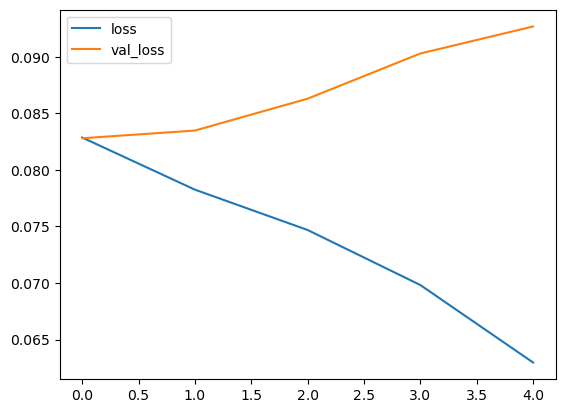

In [125]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [90]:
## Evaluate on Test Data

In [126]:
scaled_test_traces_lengths = list(map(len, scaled_test_traces))
# Get the longest trace
longest_scaled_test_trace = max(scaled_test_traces_lengths)
print(f'Length of longest test trace: {longest_scaled_test_trace}')
index_longest_scaled_test_trace = scaled_test_traces_lengths.index(max(scaled_test_traces_lengths))
print(f'Index of longest test trace: {index_longest_scaled_test_trace}')

scaled_test_traces[657]

Length of longest test trace: 50
Index of longest test trace: 657


[{'x': 0.7017504821243139,
  'y': 0.8931909212283045,
  'obj_dom_pos': [1,
   1,
   15,
   2,
   2,
   14,
   3,
   3,
   13,
   3,
   6,
   10,
   4,
   4,
   12,
   4,
   5,
   11,
   4,
   7,
   9,
   4,
   8,
   8,
   5,
   9,
   7,
   5,
   13,
   3,
   6,
   10,
   6,
   6,
   11,
   5,
   6,
   12,
   4,
   6,
   14,
   2,
   6,
   15,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
 

In [127]:
my_prediction_trace = index_longest_scaled_test_trace
scaled_test = scaled_test_traces[my_prediction_trace]

In [190]:
test_predictions = []

first_eval_batch = scaled_test[:length] # Use first batch from a test set and predict the next value
first_eval_batch = [first_eval_batch] # Must be wrapped in an array to represent shape of X (here: only one entry)
first_eval_batch = transform_X_to_inputs(first_eval_batch)
current_batch = first_eval_batch

print(current_batch)

# Of course cannot predict more than one step, as we only predict gesture_pos_x and gesture_pos_y and not the whole tree
# for i in range(len(scaled_test)):
# 
#   # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
#   current_pred = model.predict(current_batch)[0]
# 
#   # store prediction
#   test_predictions.append(current_pred)
#   
#   # drop first value
#   current_batch = [feat_input[:,1:,:] for feat_input in current_batch]
# 
#   # update batch to now include prediction
#   current_batch = np.append(current_batch,[[current_pred]],axis=1)

[array([[[0.70175048],
        [0.73497997],
        [0.92723632],
        [0.71361816],
        [0.87501854]]]), array([[[0.89319092],
        [0.86915888],
        [0.15487316],
        [0.89052069],
        [0.63017356]]]), array([[[  1,   1,  15, ...,   0,   0,   0],
        [  1,   1,  32, ...,   0,   0,   0],
        [  1,   1, 146, ...,   0,   0,   0],
        [  1,   1,  12, ...,   0,   0,   0],
        [  1,   1, 148, ...,   0,   0,   0]]])]


In [193]:
# Current prediction only
current_pred = model.predict(current_batch)
print(current_pred)
test_predictions.append(current_pred[0]) # Model only predicts one gesture per batch, this can be "easily" changed by handing over a batch of labels during training
test_predictions

1/1 [==============================] - 0s 24ms/step
[[0.8297629 0.832512 ]]


[array([0.8297629, 0.832512 ], dtype=float32),
 array([0.8297629, 0.832512 ], dtype=float32),
 array([0.8297629, 0.832512 ], dtype=float32)]

In [200]:
test_predictions = np.array(test_predictions)
test_predictions

array([[0.8297629, 0.832512 ],
       [0.8297629, 0.832512 ],
       [0.8297629, 0.832512 ]], dtype=float32)

In [202]:
next_values = scaled_test[length:length + 3] # Remove the first batch and just select the next one, as we don't predict more right now
next_labels = transform_y_to_labels(next_values)
next_labels = np.transpose(next_labels, (1,0))
next_labels

array([[0.85365673, 0.09212283],
       [0.23179054, 0.52069426],
       [0.81568017, 0.08277704]])

In [206]:
if isScale:
  # TODO: validate
  true_predictions_labels = scaler_invert(test_predictions)
  true_next_labels = scaler_invert(next_labels)
else:
  true_predictions_labels = test_predictions
  true_next_labels = next_labels

comparison = np.concatenate([true_next_labels, true_predictions_labels], axis=1)
comparison_df = pd.DataFrame(comparison, columns=['x','y','PredictionsX', 'PredictionsY'])
comparison_df

,x,y,PredictionsX,PredictionsY
0,0.853657,0.092123,0.829763,0.832512
1,0.231791,0.520694,0.829763,0.832512
2,0.815680,0.082777,0.829763,0.832512


<AxesSubplot: >

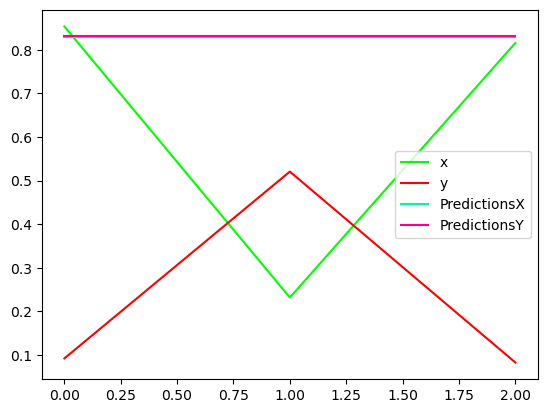

In [207]:
comparison_df.plot(color = ['#00FF00', '#FF0000', '#00FF88', '#FF0088'])

In [209]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(comparison_df['x'],comparison_df['PredictionsX'])))
print(np.sqrt(mean_squared_error(comparison_df['y'],comparison_df['PredictionsY'])))

0.3456106474363052
0.6344312460996537
